In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image


In [39]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  # scale = max_dim / long_dim

  # new_shape = tf.cast(shape * scale, tf.int32)

  # img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [40]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [41]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)
print(vgg.get_layer(vgg.layers[0].name))
print(vgg.input)



input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")


In [42]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 459, 612, 3)


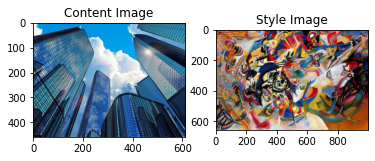

In [43]:
content_path = './build.jpg'
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_layers = ['block5_pool'] 
# content_layers=vgg.layers
content_image = load_img(content_path)
style_image = load_img(style_path)
print(content_image.shape)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
style_layers=[]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [44]:
from keras.layers import AveragePooling2D, MaxPooling2D, Input, Conv2D
def vgg_layers(layer_names,shape):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  sh=(shape[1],shape[2],shape[3])
  vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=sh)
  vgg.trainable = False  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  model.summary()
  return model

In [45]:
print(style_image.shape)
content_extractor = vgg_layers(content_layers,style_image.shape)
content_outputs = content_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, content_outputs):
  print(name)
  # print("  shape: ", output.numpy().shape)
  # print("  min: ", output.numpy().min())
  # print("  max: ", output.numpy().max())
  # print("  mean: ", output.numpy().mean())
  # print()

(1, 657, 1000, 3)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 657, 1000, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 657, 1000, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 657, 1000, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 328, 500, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 328, 500, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 328, 500, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 164, 

In [46]:
class ContentModel(tf.keras.models.Model):
  def __init__(self, content_layers,shape):
    super(ContentModel, self).__init__()
    self.vgg = vgg_layers(content_layers,shape)
    self.content_layers = content_layers
    self.vgg.trainable = False
    self.shape=shape

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    
    content_outputs=outputs[:len(self.content_layers)]
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, [content_outputs])}
    return content_dict

In [47]:
image = tf.Variable(content_image)
shape=image.shape
extractor = ContentModel(content_layers, image.shape)

results = extractor(tf.constant(content_image))
print("Contents:")
for name, output in sorted(results.items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 459, 612, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 459, 612, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 459, 612, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 229, 306, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 229, 306, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 229, 306, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 114, 153, 128)     0   

In [48]:
content_targets = extractor(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.04,
    decay_steps=100,
    decay_rate=0.8,
    staircase=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.99, epsilon=1e-1)
content_weight=(1e3 if ((image.shape[1]+image.shape[2])<400) else 1e4)  if ((image.shape[1]+image.shape[2])<800) else 1e5
total_variation_weight=(10 if ((image.shape[1]+image.shape[2])<400) else 20)  if ((image.shape[1]+image.shape[2])<800) else 30



In [49]:
def style_content_loss(outputs):
    
    content_outputs = outputs
    co=content_outputs['block5_pool']
    ct=content_targets['block5_pool']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss =  content_loss
    return loss

In [50]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

In [51]:
train_step(image)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([7045889.5], dtype=float32)>

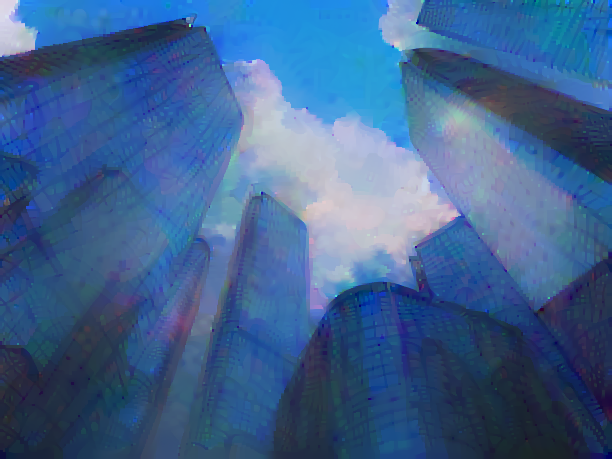

tf.Tensor(16095.625, shape=(), dtype=float32)
Train step: 900
....................................................................................................ERLY STOP[PING
Total time: 143.8


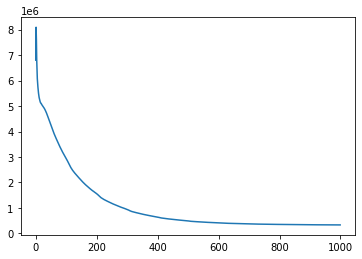

In [52]:
import time
import IPython.display as display

start = time.time()

epochs = 20
steps_per_epoch = 100
lossarr=[]
step = 0
for n in range(epochs):
  l=0
  for m in range(steps_per_epoch):
    step += 1
    l=train_step(image)
    lossarr.append(l)
    print(".", end='', flush=True)
  tdif=tf.reduce_sum(lossarr[-20:-1]-lossarr[-1])
  
  if(tdif<10000):
    print("ERLY STOP[PING")
    break
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print(tdif)
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
plt.plot(lossarr)

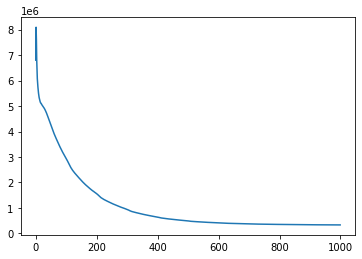

In [53]:
plt.plot(lossarr)

In [54]:
p=np.array([1,2,3,4,5,6,7,8,9])
p-2

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [55]:
tf.reduce_sum(lossarr[-200:-180]-lossarr[-180])

<tf.Tensor: shape=(), dtype=float32, numpy=30272.156>

In [56]:
tf.reduce_sum(lossarr[-100:-80]-lossarr[-80])

<tf.Tensor: shape=(), dtype=float32, numpy=17270.906>

In [57]:
tf.reduce_sum(lossarr[-400:-380]-lossarr[-380])

<tf.Tensor: shape=(), dtype=float32, numpy=105795.5>

In [58]:
tf.reduce_sum(lossarr[-20:-1]-lossarr[-1])

<tf.Tensor: shape=(), dtype=float32, numpy=9852.5625>

In [59]:
tf.reduce_sum(lossarr[-800:-780]-lossarr[-780])

<tf.Tensor: shape=(), dtype=float32, numpy=1955664.2>

In [4]:
import datetime
fold=(str)((int)(datetime.datetime.now().timestamp()))
print('a'+fold)

a1658895689


In [2]:
import os
os.path.basename('D:/Downloads/download')

'download'

(2, 20, 1)


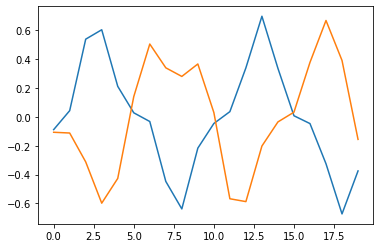

In [26]:
import numpy as np
import matplotlib.pyplot as plt
freq1,freq2,offset1,offset2=np.random.rand(4,2,1)
time=np.linspace(0,1,20)
series=0.5*np.sin((time-offset1)*(freq1*10+10))

series+=0.2*np.sin((time-offset2)*(freq2*20+20))

series+=0.1*(np.random.rand(2,20)-0.5)
series=series[:,:,np.newaxis].astype(np.float32)
print(series.shape)
plt.plot(series[0])
plt.plot(series[1])



In [28]:
import numpy as np
import matplotlib.pyplot as plt
batch_size=50
n_steps=100
freq1,freq2,off1,off2=np.random.rand(4,batch_size,1)
time=np.linspace(0,1,n_steps)
series=0.5*np.sin((time-offset1)*10+10)
print(series.shape)

series+=0.2*np.sin((time-offset2)*20+20)
print(series.shape)
series+=0.1*(np.random.rand(batch_size,n_steps)-0.5)
plt.plot(series[0])

(2, 100)


ValueError: operands could not be broadcast together with shapes (2,100) (50,100) (2,100) 